--2024-12-03 11:37:37--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip.3’

stanford_dogs.zip.3 100%[===================>] 739.01M  10.7MB/s    in 72s     

2024-12-03 11:38:50 (10.3 MB/s) - ‘stanford_dogs.zip.3’ saved [774907490/774907490]

Удалено изображений: 10
Found 20570 files belonging to 120 classes.
Using 14399 files for training.
Using 6171 files for validation.
Содержит:
25 батча для валидации,
24 батча для тестов
Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier',

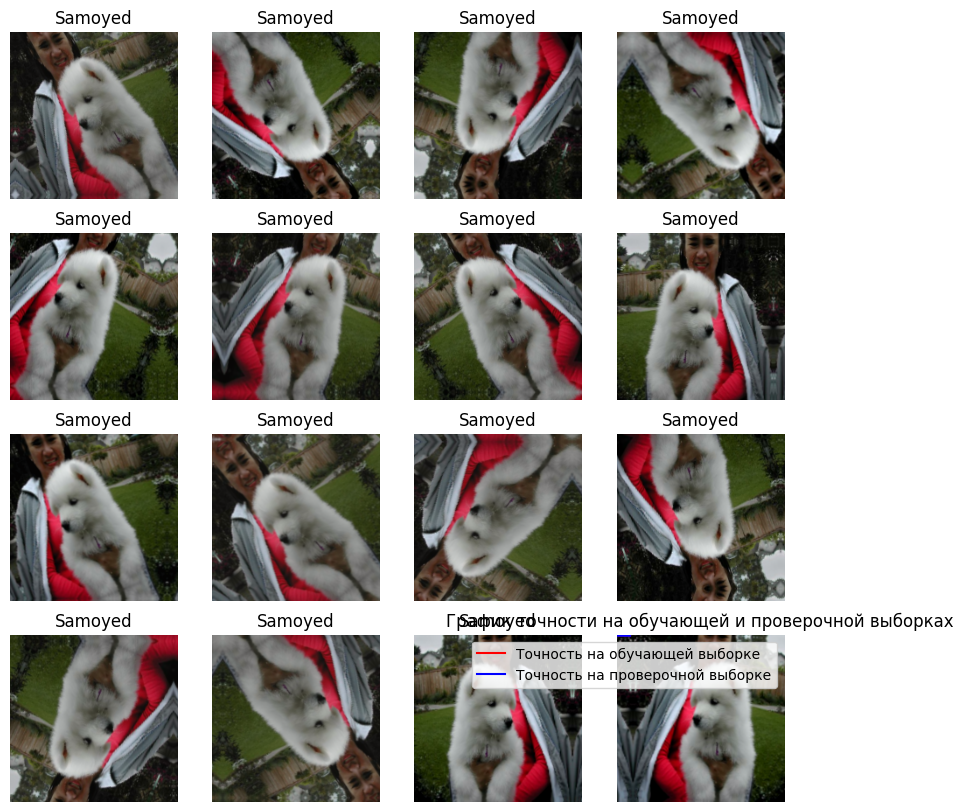

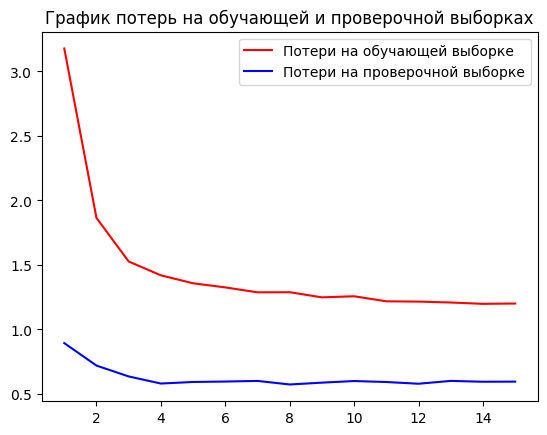

In [ ]:
!pip install --upgrade keras==3.0

import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications import EfficientNetV2B0

import warnings
warnings.filterwarnings('ignore')

!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
!unzip -qo "stanford_dogs" -d ./dataset

IMAGE_PATH = './dataset/'

IMAGE_SIZE = (192, 192)
BATCH_SIZE = 128

num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.3,
    subset="both",
    seed=20,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Делим выборку на тестовую и валидационную
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

print(f"Содержит:\n{len(val_ds)} батча для валидации,\n{len(test_ds)} батча для тестов")

CLASS_LIST = sorted(os.listdir(IMAGE_PATH))
CLASS_COUNT = len(CLASS_LIST)

print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
    layers.RandomContrast(factor=0.1), # случайное изменение контрастности
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

# Аугментация на примере 1го изображения из 1го батча
plt.figure(figsize=(10, 10))
for images, label in train_ds.take(1):
    for i in range(16):
        augmented_images = img_augmentation(images[0])
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8"))
        plt.title("{}".format(CLASS_LIST[label[0]])) # Вывод метки
        plt.axis("off")


# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE,)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE,)

test_ds = test_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE,)

# Предварительная выборка примеров в память GPU или оперативную память
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = '{epoch:02d}-{val_acc:.2f}.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

test_loss, test_acc = model.evaluate(test_ds)
print('Точность на контрольной выборке:', test_acc)


# Функция отрисовки графиков
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

show_plot(history)
